In [18]:
import os, csv
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras import layers, Input
from keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import csv
import os,random

from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM
from keras.layers.convolutional import Convolution1D
from keras.layers.core import Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import *
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

import datetime
now = datetime.datetime.now

In [19]:
def process(temp):
    min_len = 3000
    for i in range(11):
        j = 0
        while temp[j][i] != '' and j<len(temp)-1:
            j+=1
        min_len = min(min_len, j);
#     print(min_len)
    return temp[:min_len]

In [20]:
types = {'B_ID':8, 'E_ID':17, 'NE_ID':27, 'S_ID':10, 'P_ID':16}
x_val = []
x_id = []
for ids, vals in types.items():
    for i in range(1,vals+1):
        x_id.append(ids + str(i))
        try: 
            with open("../po-cf-ex-1-features/"+ids+str(i)+".csv", 'r') as f:
                temp = list(csv.reader(f, delimiter = ","))
            temp = process(temp)
            temp = np.asarray(temp)
            temp = temp.astype(np.float64)
        except:
            print("Problem in:", ids, i)
            continue
        x_val.append(temp.tolist())
x_val = np.asarray(sequence.pad_sequences(x_val, maxlen=600)).astype(np.float64)
print("x_val shape:", x_val.shape)

Problem in: E_ID 8
x_val shape: (77, 600, 11)


In [23]:
po_val = []
cf_val = []
for ids in x_id:
    try:
        df = pd.read_excel("../KiMoRe/"+ids+"/Es1/Label/ClinicalAssessment_"+ids+".xlsx")
    except:
        print("problem in: ", ids)
        continue
    df = np.array(df).reshape((16,))
    po_val.append(df[6])
    cf_val.append(df[11])
po_val = np.asarray(po_val).astype(np.float64)
cf_val = np.asarray(cf_val).astype(np.float64)
ts_val = po_val+cf_val
print("shape of CF: ", cf_val.shape)
print("shape of PO: ", po_val.shape)
print("shape of TS: ", ts_val.shape)
# print(po_val)
for i in range(len(ts_val)):
    if np.isnan(ts_val[i]):
        print(i)
print(ts_val)


problem in:  E_ID8
shape of CF:  (77,)
shape of PO:  (77,)
shape of TS:  (77,)
23
[41.         38.         28.21008112 33.3397327  44.33333333 45.33333333
 40.33333333 44.33333333 48.33333333 49.33333333 42.66666667 44.66666667
 46.         46.66666667 50.         50.         48.33333333 50.
 50.         46.33333333 44.         50.         47.                 nan
 39.66666667 41.         44.33333333 46.33333333 40.66666667 43.66666667
 42.         40.         42.         34.         46.         40.
 50.         50.         45.         47.         47.         38.
 50.         46.         46.         43.         41.         50.
 47.         49.         49.         27.         34.         44.
 26.         32.89508774 38.41075339 26.66666667 36.         26.33333333
 33.66666667 48.         27.         50.         14.         33.
 50.         22.         32.         40.         34.3081805  14.66666667
 35.66666667 36.66666667 36.         27.66666667 37.        ]


In [24]:
def jumble_up(val):
    return np.random.permutation(val)

In [25]:
indices = np.arange(len(ts_val))
indices = jumble_up(indices)
print(indices)
temp_x = x_val
temp_ts = ts_val
for i in range(len(ts_val)):
    x_val[i] = temp_x[indices[i]]
    ts_val[i] = temp_ts[indices[i]]

[69 19 72 25 39 21 50  8 37 32 13 34 36 62 53 35 43 24 14 55 18 47 60 68
 46 26 58  2 29 23 56 17 75 30 57 70 52 76 22 42 66 31 44 49 54  4  9 28
 40 33 74  1 11 65  7 59  0 15 45 12 41  3 63 27 71 73 67 10  6 48  5 16
 64 51 38 20 61]


In [26]:
x_val /= np.max(np.abs(x_val))
ts_val /= np.max(np.abs(ts_val))
x_train, x_test, y_train, y_test = train_test_split(x_val,ts_val, test_size=0.3)
print(y_train)

[0.73333333 0.71333333 0.94       0.76821507 0.98       0.64
 0.8        0.68616361 0.92       1.         0.98       0.55333333
 0.92       0.79333333 1.         0.8        0.52666667 0.82
 0.84       0.76821507 1.         0.88       0.93333333 0.79333333
 1.         0.67333333 0.92666667 0.79333333 1.         0.53333333
 0.79333333 0.74       0.82       0.29333333 1.         0.72
 0.67333333 0.71333333 0.94       0.72       0.65790175 0.64
 0.92       0.94       0.54       0.92666667 0.87333333 0.71333333
 0.98       0.52       0.67333333 1.         0.96666667]


In [27]:
timesteps = 600 
nr = 77   
n_dim = 11  
dropout_rate = 0.1

In [28]:
def Network():
    model = Sequential()
    model.add(Convolution1D(100, 5, padding ='same', strides = 2, input_shape = (timesteps,n_dim)))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Convolution1D(30, 3, padding ='same', strides = 2))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Convolution1D(10, 3, padding ='same'))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Flatten())

    model.add(Dense(200))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Dense(100))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))


    model.compile(loss='binary_crossentropy', optimizer=Adam())
    
    # Early stopping if the validaton Loss does not decrease for 100 epochs
    early_stopping = EarlyStopping(monitor='val_loss', patience = 100)

    t = now()
    history = model.fit(x_train, y_train, batch_size=5, epochs=500, verbose=1, 
                     validation_data=(x_test, y_test),
                     callbacks = [early_stopping])
    print('Training time: %s' % (now() - t))
    
    # Plot the results
    plt.figure(1)
    plt.subplot(221)
    plt.plot(history.history['loss'])
    plt.title('Training Loss')
    plt.subplot(222)
    plt.plot(history.history['val_loss'])
    plt.title('Validation Loss')
    plt.tight_layout()
    plt.show()
    
    # Plot the prediction of the CNN model for the training and validation sets
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)

    plt.figure(figsize = (8,8))
    plt.subplot(2,1,1)
    plt.plot(pred_train,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
    plt.plot(y_train,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
    plt.ylim([-0.1,1.1])
    plt.title('Training Set',fontsize=18)
    plt.xlabel('Sequence Number',fontsize=16)
    plt.ylabel('Quality Scale',fontsize=16)
    plt.legend(loc=3, prop={'size':14}) # loc:position
    plt.subplot(2,1,2)
    plt.plot(pred_test,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
    plt.plot(y_test,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
    plt.title('Testing Set',fontsize=18)
    plt.ylim([-0.1,1.1])
    plt.xlabel('Sequence Number',fontsize=16)
    plt.ylabel('Quality Score',fontsize=16)
    plt.legend(loc=3, prop={'size':14}) # loc:position
    plt.tight_layout()
#     plt.savefig('../../Results/CNN_Vicon_Scores.png', dpi=300)
    plt.show()
    
    
    # Calculate the cumulative deviation and rms deviation for the validation set
    test_dev = abs(np.squeeze(pred_test)-y_test)
    # Cumulative deviation
    mean_abs_dev = np.mean(test_dev)
    # RMS deviation
    rms_dev = sqrt(mean_squared_error(pred_test, y_test))
    print('Mean absolute deviation:', mean_abs_dev)
    print('RMS deviation:', rms_dev)
    
    return mean_abs_dev, rms_dev

Epoch 1/500
11/11 [==============================] - 1s 32ms/step - loss: 0.5831 - val_loss: 0.4505
Epoch 2/500
11/11 [==============================] - 0s 24ms/step - loss: 0.5192 - val_loss: 0.4478
Epoch 3/500
11/11 [==============================] - 0s 18ms/step - loss: 0.5194 - val_loss: 0.4554
Epoch 4/500
11/11 [==============================] - 0s 23ms/step - loss: 0.5172 - val_loss: 0.4230
Epoch 5/500
11/11 [==============================] - 0s 15ms/step - loss: 0.4850 - val_loss: 0.4078
Epoch 6/500
11/11 [==============================] - 0s 22ms/step - loss: 0.4544 - val_loss: 0.4274
Epoch 7/500
11/11 [==============================] - 0s 20ms/step - loss: 0.4700 - val_loss: 0.4270
Epoch 8/500
11/11 [==============================] - 0s 15ms/step - loss: 0.4622 - val_loss: 0.3938
Epoch 9/500
11/11 [==============================] - 0s 15ms/step - loss: 0.4820 - val_loss: 0.3929
Epoch 10/500
11/11 [==============================] - 0s 20ms/step - loss: 0.4181 - val_loss: 0.3982

11/11 [==============================] - 0s 23ms/step - loss: 0.4721 - val_loss: 0.3890
Epoch 83/500
11/11 [==============================] - 0s 17ms/step - loss: 0.4693 - val_loss: 0.3872
Epoch 84/500
11/11 [==============================] - 0s 21ms/step - loss: 0.4377 - val_loss: 0.3946
Epoch 85/500
11/11 [==============================] - 0s 31ms/step - loss: 0.4145 - val_loss: 0.3933
Epoch 86/500
11/11 [==============================] - 0s 20ms/step - loss: 0.4334 - val_loss: 0.3860
Epoch 87/500
11/11 [==============================] - 0s 16ms/step - loss: 0.4220 - val_loss: 0.3953
Epoch 88/500
11/11 [==============================] - 0s 19ms/step - loss: 0.4339 - val_loss: 0.3974
Epoch 89/500
11/11 [==============================] - 0s 23ms/step - loss: 0.4110 - val_loss: 0.3973
Epoch 90/500
11/11 [==============================] - 0s 16ms/step - loss: 0.4353 - val_loss: 0.3943
Epoch 91/500
11/11 [==============================] - 0s 21ms/step - loss: 0.4225 - val_loss: 0.3895
Epo

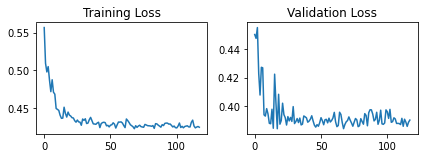

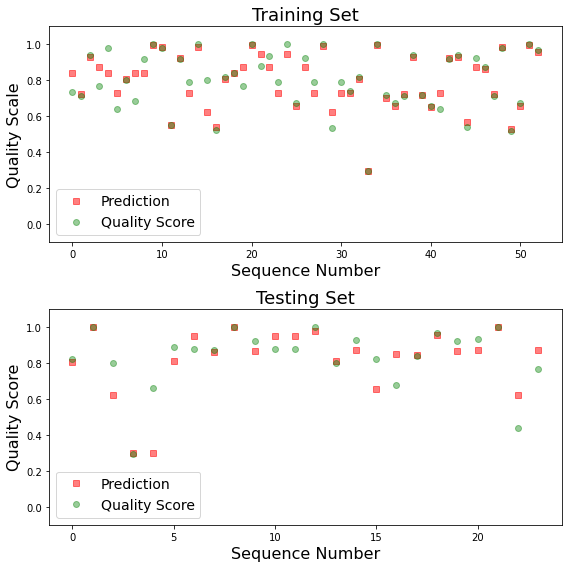

Mean absolute deviation: 0.07230541906319148
RMS deviation: 0.11099173713317584


In [29]:
Mean_abs_dev, RMS_dev  = Network()